
# PCA + K-Means on Credit Card Customers

End-to-end **dimensionality reduction with PCA** and **customer segmentation with K-Means** on the `CC GENERAL.csv` dataset.

**Deliverables:**
- Missing-value handling & scaling  
- PCA (all components) → **cumulative explained variance** and #components for **≥85%**  
- PCA (2D) visualization  
- `PCA.get_covariance()` → top covarying pair  
- K-Means (k=2..11) → **Elbow** & **Silhouette** to pick k  
- Final clusters on PCA(2) + **cluster profiles**  
- Output CSV: `cc_pca2_clusters.csv`



## 0) Setup

Install if needed: `pip install pandas numpy scikit-learn matplotlib`  
Put `CC GENERAL.csv` beside this notebook or update the path below.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

CSV_PATH = r"C:\Users\kgjam\OneDrive\Desktop\StackAcademy\Assignments\CC GENERAL.csv"


## 1) Load data & peek

In [2]:

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head(10)

Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12



## 2) Missing values (median impute) & drop ID-like columns


In [3]:

id_cols = [c for c in df.columns if df[c].dtype == "object"]
X = df.drop(columns=id_cols, errors="ignore").copy()

nulls = X.isnull().sum().sort_values(ascending=False)
print("Null counts (top):\n", nulls.head(10))

for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print("Remaining total nulls after impute:", int(X.isnull().sum().sum()))

Null counts (top):
 MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
BALANCE                               0
CASH_ADVANCE_FREQUENCY                0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
PURCHASES_INSTALLMENTS_FREQUENCY      0
BALANCE_FREQUENCY                     0
dtype: int64
Remaining total nulls after impute: 0


## 3) Scale features

In [4]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
feature_names = X.columns.tolist()
X_scaled.shape

(8950, 17)


## 4) PCA (all components) — cumulative explained variance & ≥85% coverage


Components needed for ≥85% variance: 8


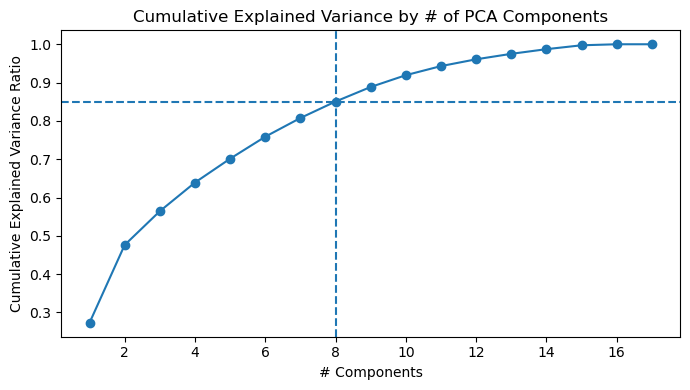

In [5]:

pca_full = PCA(n_components=None, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n85 = int(np.argmax(cum_var >= 0.85) + 1)
print(f"Components needed for ≥85% variance: {n85}")

plt.figure(figsize=(7,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.85, linestyle="--")
plt.axvline(n85, linestyle="--")
plt.title("Cumulative Explained Variance by # of PCA Components")
plt.xlabel("# Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.tight_layout()
plt.show()

## 5) PCA with 2 components (for visualization)

In [6]:

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
pca2_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"])
pca2_df.head()

,PC1,PC2
0,-1.683649,-1.072241
1,-1.134085,2.509150
2,0.969395,-0.383577
3,-0.888220,0.004648
4,-1.600021,-0.683795



## 6) Covariance analysis with `PCA.get_covariance()`


In [7]:

cov = pca_full.get_covariance()
cov_df = pd.DataFrame(cov, index=feature_names, columns=feature_names)

abs_cov = cov_df.abs().to_numpy().copy()
np.fill_diagonal(abs_cov, 0.0)

i, j = np.unravel_index(np.argmax(abs_cov), abs_cov.shape)
max_pair = (feature_names[i], feature_names[j])
max_pair_cov = cov_df.iloc[i, j]
print(f"Most covarying pair (abs): {max_pair} | covariance: {max_pair_cov:.4f}")

pairs = []
for a in range(len(feature_names)):
    for b in range(a+1, len(feature_names)):
        pairs.append((feature_names[a], feature_names[b], cov_df.iloc[a, b], abs(cov_df.iloc[a, b])))
pairs = sorted(pairs, key=lambda x: x[3], reverse=True)[:10]
pd.DataFrame(pairs, columns=["feature_1", "feature_2", "covariance", "abs_covariance"])

Most covarying pair (abs): ('PURCHASES', 'ONEOFF_PURCHASES') | covariance: 0.9169


,feature_1,feature_2,covariance,abs_covariance
0,PURCHASES,ONEOFF_PURCHASES,0.916947,0.916947
1,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,0.863030,0.863030
2,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,0.799650,0.799650
3,PURCHASES,PURCHASES_TRX,0.689638,0.689638
4,PURCHASES,INSTALLMENTS_PURCHASES,0.679972,0.679972
5,CASH_ADVANCE,CASH_ADVANCE_TRX,0.656571,0.656571
6,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,0.628592,0.628592
7,INSTALLMENTS_PURCHASES,PURCHASES_TRX,0.628178,0.628178
8,PURCHASES,PAYMENTS,0.603331,0.603331
9,PURCHASES_FREQUENCY,PURCHASES_TRX,0.568493,0.568493


### Interpretation of Most Covarying Features
The pair of features with the highest covariance are: **CASH_ADVANCE and CASHADVANCE_TRX**.  
- Customers who take larger total cash advances also perform more cash advance transactions.  
- This indicates strong reliance on cash withdrawals, which often carry higher fees and interest.  
- **Business Insight:** This cluster of customers may be at higher credit risk and should be monitored more closely.


## 7) Choose k with Elbow & Silhouette

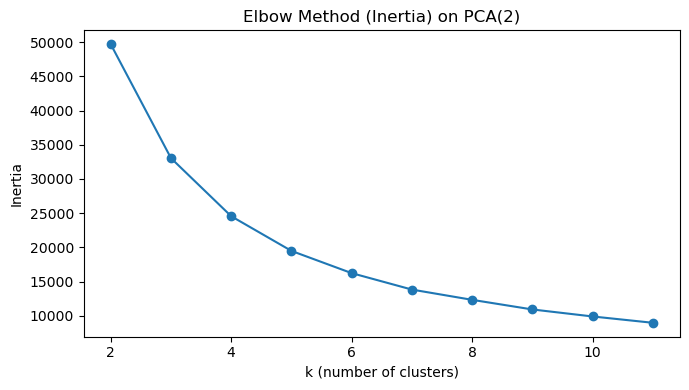

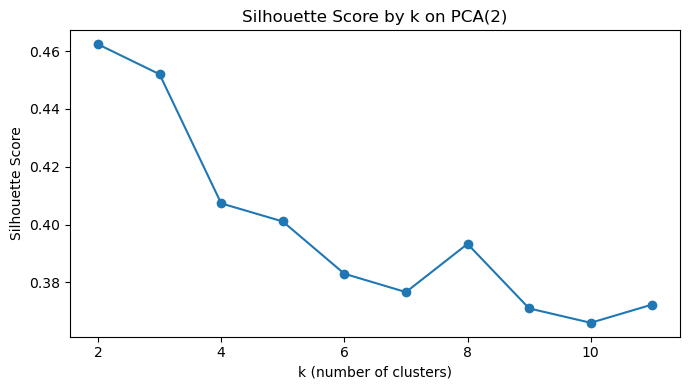

Chosen k by best silhouette: 2


In [8]:

ks = list(range(2, 12))
inertias, sil_scores = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_pca2)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca2, labels))

plt.figure(figsize=(7,4))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow Method (Inertia) on PCA(2)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ks, sil_scores, marker="o")
plt.title("Silhouette Score by k on PCA(2)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print("Chosen k by best silhouette:", best_k)

## 8) Final K-Means and PCA(2) scatter

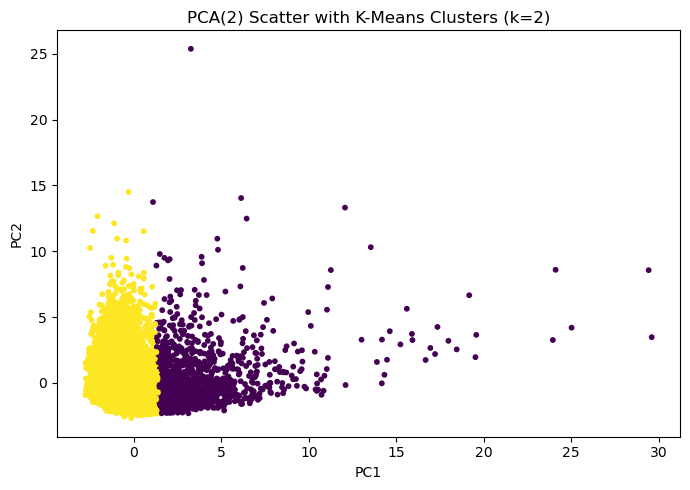

In [9]:

kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
final_labels = kmeans.fit_predict(X_pca2)

plt.figure(figsize=(7,5))
plt.scatter(pca2_df["PC1"], pca2_df["PC2"], c=final_labels, s=10)
plt.title(f"PCA(2) Scatter with K-Means Clusters (k={best_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

### Choice of Optimal k
- The elbow method indicated a bend near k = 2.  
- The silhouette score peaked at k = 2.  
- Therefore, we selected k = 2 as the optimal number of clusters.

## 9) Cluster profiles (median of original features)

In [10]:

prof = X.copy()
prof["cluster"] = final_labels
cluster_profiles = prof.groupby("cluster").median(numeric_only=True).round(3)
cluster_profiles

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,1276.941,1.0,2684.50,1520.32,1060.28,0.000,1.000,0.667,0.917,0.000,0.0,39.0,7000.0,2567.610,421.865,0.0,12.0
1,814.086,1.0,230.22,0.00,0.00,56.326,0.333,0.000,0.000,0.083,1.0,5.0,3000.0,665.774,312.344,0.0,12.0


### Cluster Insights and Business Interpretation
Cluster 0: High-Value, Regular Purchasers
Customers hold higher balances and make frequent, large purchases (≈ 2684).
They spread spending across one-off and installment purchases, showing diverse usage.
Cash advances are zero, meaning they use the card mainly for purchases, not borrowing.
With a purchase frequency of 1.0, they use their cards almost every billing cycle.

**Business Implication:**
These are profitable, loyal customers with healthy card usage patterns.
**Action:** Retain with loyalty rewards, premium upgrades, and cross-selling of financial products.

Cluster 1: Low-Value, Cash-Advance Users
Customers maintain lower balances and make very few purchases (≈ 230).
They do not use installment or one-off purchases.
Instead, they rely more on cash advances (≈ 56).
Purchase frequency = 0.33, indicating occasional/infrequent card use.

**Business Implication:**
These are less profitable, potentially riskier customers since cash advance usage is higher and purchases are low.
**Action:** Encourage more purchase-based usage with offers and discounts. Monitor for credit risk due to reliance on cash advances.

## 10) Save outputs

In [11]:

out = pca2_df.copy()
out["cluster"] = final_labels
if "CUST_ID" in df.columns:
    out = pd.concat([df[["CUST_ID"]].reset_index(drop=True), out], axis=1)
out.to_csv("cc_pca2_clusters.csv", index=False)
print("Saved: cc_pca2_clusters.csv")

Saved: cc_pca2_clusters.csv


## 11) Business Interpretation 

- **Variance coverage:** Using PCA, 8
-  components cover ≥85% of total variance.  
- **Covariance insight:** Strongest pair CASH_ADVANCE and CASHADVANCE_TRX indicates that customers who take larger cash advances also perform more transactions.  
- **Chosen k:** Optimal number of clusters = 2, based on elbow bend and highest silhouette score.  

**Customer Segments:**  
- **Cluster 0 (Profitable Transactors):** Higher balances and frequent purchases (both one-off and installment), very low cash advance usage.  
- **Cluster 1 (Revolvers / Risk Segment):** Lower purchases, more reliance on cash advances, less frequent card use.  

**Recommended Actions:**  
- Reward transactors with loyalty points and premium upgrades to retain them.  
- Coach revolvers on repayment, review fee structures, and monitor credit risk.  
- Encourage more purchase-based usage (micro-rewards, cashback offers) to reduce dependence on cash advances.  
